In [1]:
!pip install transformers
!pip install gensim
!pip install pymorphy2

     |████████████████████████████████| 2.9 MB 5.0 MB/s 
     |████████████████████████████████| 895 kB 54.4 MB/s 
     |████████████████████████████████| 56 kB 4.2 MB/s 
     |████████████████████████████████| 3.3 MB 33.5 MB/s 
     |████████████████████████████████| 596 kB 66.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 55 kB 2.4 MB/s 
     |████████████████████████████████| 8.2 MB 8.0 MB/s 


In [2]:
import torch
import numpy as np
import gensim
import os
from tqdm import tqdm
import random
import pymorphy2
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
import pandas as pd
from keras.preprocessing.sequence import pad_sequences
from scipy.spatial import distance

random.seed(44)
morph = pymorphy2.MorphAnalyzer()
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
from google.colab import drive
# drive.flush_and_unmount()
drive.mount('/content/drive')

Mounted at /content/drive


### Navec Russian dataset

In [4]:
!pip install navec
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

--2021-10-17 06:24:38--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar’

navec_hudlit_v1_12B 100%[===================>]  50.56M  15.9MB/s    in 3.2s    

2021-10-17 06:24:42 (15.9 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar’ saved [53012480/53012480]



In [5]:
from navec import Navec

In [6]:
path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)

In [7]:
navec['хороший'].shape

(300,)

### Predict mask by cosine + bert. First word created random

In [8]:
categories = np.array(["животные", "музыка", "спорт", "литература"])
categories_eng = np.array(["animals", "music", "sport", "literature"])
data_dir = '/content/drive/MyDrive/datasets/AIIJC/'
keywords_dir = data_dir + 'bright_keywords'

with open(keywords_dir + '/keywords_tasks.txt', 'r') as f:
  words = f.read()
  words = [morph.parse(token.lower())[0].normal_form for token in words.split('\n')]
  keywords_tasks = set(words)

nouns_actors = [[] for i in range(4)]
for i, cat in enumerate(categories_eng):
  with open(keywords_dir + f'/actors/true_keywords_nouns_actors_{cat}.txt', 'r') as f:
    words = f.read()
  
  for el in words.split('\n')[:-1]:
    if not el in keywords_tasks:
      nouns_actors[i].append(el)

  

nouns = [[] for i in range(4)]
for i, cat in enumerate(categories_eng):
  with open(keywords_dir + f'/nouns/true_keywords_nouns_{cat}.txt', 'r') as f:
    words = f.read()
  for el in words.split('\n')[:-1]:
    if not el in keywords_tasks:
      nouns[i].append(el)

  with open(keywords_dir + f'/wow_keywords/wow_keywords_{cat}.txt', 'r') as f:
    words = f.read()
  for el in words.split('\n')[:-1]:
      if not el in keywords_tasks and 'NOUN' in morph.parse(el)[0].tag:
        nouns[i].append(el)


In [14]:
from typing import List
class MaskCreator():
  def __init__(self, bigram_model, nouns, nouns_actors):
    self.morph = pymorphy2.MorphAnalyzer()
    self.tokenizer = nltk.WordPunctTokenizer()
    self.bigram_mod = gensim.models.Phrases.load(bigram_model)
    self.nouns = nouns
    self.nouns_actors = nouns_actors

  def make_bigrams(self, doc):
      return self.bigram_mod[doc]
  
  def mask(self, text, category=4):
    masks_dict = []
    tokens = self.tokenizer.tokenize(text.lower())
    tokens_normal = [self.morph.parse(w)[0].normal_form for w in tokens]
    tokens_bigrammed = self.make_bigrams(tokens_normal)
    
    if len(tokens_bigrammed) < len(tokens):
      ind_go = 0
      for i in range(len(tokens_bigrammed)):
        if tokens_normal[ind_go] != tokens_bigrammed[i]:
          tokens = tokens[:ind_go] + [tokens_bigrammed[i]] + tokens[ind_go+2:]
          ind_go += 2
        else:
          ind_go += 1

    if category == 4:
      now_keywords = self.nouns[0] + self.nouns[1] + self.nouns[2] + self.nouns[3]
    else:
      now_keywords = self.nouns[category] + self.nouns_actors[category]

    prev_words = []
    for ind, token in enumerate(tokens):
      word = self.morph.parse(token.lower())[0].normal_form
      if word in now_keywords:
        if word not in masks_dict:
          masks_dict.append(word)
        prev_words.append(tokens[ind])
        tokens[ind] = 'mask' + str(masks_dict.index(word, 0))
    text = nltk.tokenize.treebank.TreebankWordDetokenizer().detokenize(tokens)
    return text, masks_dict

In [11]:
for i in range(4):
  nouns_actors[i] = [word for word in nouns_actors[i] if navec.get(word) is not None]

In [15]:
mask_creator = MaskCreator(os.path.join(data_dir, 'bigram_model.pkl'),
                           nouns, 
                           nouns_actors)

In [13]:
def find_best(ideal_dist, vocab, new_masks, top_k=1):
  top = []
  for i in range(top_k):
    min_val = 1
    min_new_word = ''
    for new_word in vocab:
      if not new_word in navec \
            or new_word in new_masks \
            or new_word in top:
        continue
      now_dist = distance.cosine(navec[new_word], ideal_dist)
      if now_dist < min_val:
        min_val = now_dist
        min_new_word = new_word
    top.append(min_new_word)

  return top

In [16]:
def detect_class(word):
  dist = 1
  res = None
  for class_name in categories:
    now_dist = distance.cosine(navec[word], navec[class_name])
    if now_dist < dist:
      dist = now_dist
      res = class_name
  return res

In [24]:
import collections
navec_nouns = collections.defaultdict(list)
vocab_nouns = [k for k in tqdm(navec.vocab.words) if 'NOUN' in morph.parse(k)[0].tag]

for el in vocab_nouns:
  navec_nouns[detect_class(el)].append(el)

100%|██████████| 500002/500002 [01:47<00:00, 4658.04it/s]


In [81]:
find_best(navec['желудь'] + navec['спорт'] - navec['животное'], nouns[2], ['спорт'], 3)

['хоккей', 'баскетбол', 'волейбол']

In [82]:
find_best(navec['желудь'] + navec['спортсмен'] - navec['хищник'], nouns[0], ['спорт'], 3)

['альпинист', 'дуб', 'рекордсмен']

In [17]:
def convert(sentence, category_from, category_to, first_clever, second_navec_vocab, diffrent_category) :
  sentence_with_masks, masks = mask_creator.mask(sentence)
  # print(sentence_with_masks)
  new_masks = ['' for i in range(len(masks))]
  words_in_sentence = word_tokenize(sentence_with_masks)
  get_first_mask = False
  for word in words_in_sentence:
    if word[:4] == 'mask' and masks[int(word[4:])] in nouns_actors[category_from]:
      first_mask = navec[masks[int(word[4:])]]
      if first_clever:
        top = find_best(first_mask + navec[categories[category_to]] - navec[categories[category_from]], 
                             nouns_actors[category_to], [], 4)
        new_word = top[random.randint(0, 3)]
      else:
        new_word = nouns_actors[category_to][random.randint(0, 5)]

      new_first_mask = navec[new_word]
      new_masks[int(word[4:])] = new_word
      get_first_mask = True
      break

  if second_navec_vocab:
    vocab_nouns = navec_nouns[categories[category_to]]
  else:
    vocab_nouns = nouns[category_to]

  for ind, word in enumerate(words_in_sentence):
    if word[:4] == 'mask':
      if not get_first_mask:
        first_mask = navec[masks[int(word[4:])]]
        new_word = nouns[category_to][random.randint(0, 19)]
        new_first_mask = navec[new_word]
        new_masks[int(word[4:])] = new_word
        get_first_mask = True
      elif new_masks[int(word[4:])] == '':
        if navec.get(masks[int(word[4:])]) is None:
          new_masks[int(word[4:])] = masks[int(word[4:])]
          # print("None in navic")
          continue

        if diffrent_category :
          ideal_dist = navec[masks[int(word[4:])]] - navec[categories[category_from]] + navec[categories[category_to]]
        else:
          ideal_dist = new_first_mask - first_mask + navec[masks[int(word[4:])]]
        
        new_masks[int(word[4:])] = find_best(ideal_dist=ideal_dist,
                                             vocab=vocab_nouns,
                                             new_masks=new_masks)[0]
      words_in_sentence[ind] = new_masks[int(word[4:])]
  
  return ' '.join(words_in_sentence), new_masks

In [20]:
data = pd.read_csv('marked_test.csv')
data.head()

,Unnamed: 0,task,ans
0,0,Вопрос 1 Денис готовится провести соревнования...,спорт
1,1,Реши задачу.\nСколько коробок корма для собак ...,животные
2,2,"Если групп элементов несколько, то применяется...",спорт
3,3,Вопрос1 ...,животные
4,4,Для наглядной геометрической иллюстрации объём...,спорт


In [21]:
for second_navec_vocab in [False]:
  for diffrent_category in [False]:
    for i in tqdm(range(len(data))):
      category_from = np.argmax(data.at[i, 'ans'] == categories)
      sentence = data.at[i, 'task']
      for category_to in range(4):
        name = categories_eng[category_to]
        if category_from != category_to:
          data.at[i, name], _ = convert(sentence, category_from, category_to, True, second_navec_vocab, diffrent_category)


100%|██████████| 514/514 [14:39<00:00,  1.71s/it]


In [22]:
data.to_csv('result.csv')

In [127]:
data.to_csv('/content/drive/MyDrive/datasets/AIIJC/data_navic_and_keywords_predicted.csv')

In [114]:
idx = 2
print(data.at[idx, 'ans'])
for cat in categories:
  print(cat, data.at[idx, cat].replace('\n', ' ').replace('\t', ' '))

спорт
животные если групп элементов несколько , то применяется птица птичка . если необходимо выбрать элементы из одной группы и элементы из другой , то количество способов выбрать элементы из обеих групп будет равно исходя из этого , реши задачу . для получения куропатка по физической культуре учащимся нужно выбрать направление в котром бы они занимались в течение года и сдавали куропатка . по легкой отелитики предполагается 1 группа , по петух — 2 группы , по ласточка — 1 группа . сколько есть вариантов выбора навравления существует ?
музыка если групп элементов несколько , то применяется октав сложение . если необходимо выбрать элементы из одной группы и элементы из другой , то количество способов выбрать элементы из обеих групп будет равно исходя из этого , реши задачу . для получения машо по физической культуре учащимся нужно выбрать направление в котром бы они занимались в течение года и сдавали машо . по легкой отелитики предполагается 1 группа , по фортепиано — 2 группы , по го

### Bert + cosine + the main character

In [116]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
from transformers import BertTokenizer, BertForMaskedLM

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
model = BertForMaskedLM.from_pretrained("bert-base-multilingual-cased",
                                        # output_hidden_states = True
                                        )
mask = '[MASK]'

('если групп элементов несколько, то применяется mask0 mask1. если необходимо выбрать элементы из одной группы и элементы из другой, то количество способов выбрать элементы из обеих групп будет равно исходя из этого, реши задачу. для получения mask2 по физической культуре учащимся нужно выбрать направление в котром бы они занимались в течение года и сдавали mask2. по легкой отелитики предполагается 1 группа, по mask3 — 2 группы, по mask4 — 1 группа. сколько есть вариантов выбора навравления существует?',
 ['закон', 'сложение', 'зачёт', 'футбол', 'волейбол'])

In [92]:
category_from = 2
category_to = 0

new_masks = ['' for i in range(len(masks))]
words_in_sentence = word_tokenize(sentence_with_masks)

first_mask = None
first_word = None
for word in words_in_sentence:
  if word[:4] == 'mask' and masks[int(word[4:])] in nouns_actors[category_from]:
    first_word = nouns_actors[category_to][random.randint(0, 19)]
    new_masks[int(word[4:])] = new_word
    first_mask = word

In [93]:
first_mask, first_word

('mask0', 'хищник')

In [94]:
sentence_with_masks = sentence_with_masks.replace(first_mask, first_word)

In [95]:
sentence_with_masks = ' '.join([mask if 'mask' in word else word for word in sentence_with_masks.split()])

In [96]:
sentence_with_masks

'у хищник было 3 три [MASK] два из них он отдал даше. сколько [MASK] осталось у хищник?'

In [83]:
targets = ['спорт', 'музыка', 'литература', 'животные']
vocab = tokenizer.get_vocab()
dist_to_target = {target: torch.Tensor(np.zeros(len(vocab.items()))) for target in targets}
norm_words = ['.', ',', ' ']

for target in tqdm(targets):
  bad = []
  for word, idx in vocab.items():
    if navec.get(word) is None:
        if word in norm_words:
          dist_to_target[target][idx] = 0
        else :
          bad.append(word)
          dist_to_target[target][idx] = 1
    else:  
      dist_to_target[target][idx] = distance.cosine(navec[target], navec[word])

  dist_to_target[target] = np.interp(dist_to_target[target], (-1, 1), (0, 1))

100%|██████████| 4/4 [00:08<00:00,  2.03s/it]


In [84]:
def predict(sentence, convert_theme, bert_coef=1, cos_coef=1):
  tokenized = tokenizer(sentence, return_tensors="pt")
  with torch.no_grad():
    outputs = model(**tokenized)

  masked_index = np.where(torch.flatten(tokenized['input_ids']).numpy() == 103)
  for i in masked_index[0]:
    now = outputs[0][0][i]
    now = torch.Tensor(np.interp(now, (now.min(), now.max()), (0, 1)))
    predicted_index = torch.argmax(now * bert_coef + (1 - dist_to_target[convert_theme]) * cos_coef).item()
    predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])[0]
    ind = 0
    for j, word in enumerate(sentence.split()):
      if word == mask:
        ind = j
        break
    sentence = sentence.split()
    sentence[ind] = predicted_token
    sentence = ' '.join(sentence)

  return sentence

In [101]:
predict(sentence_with_masks, 'животные', 1, 0)

'time predator had 3 three [MASK], he gave two of them to Dasha. How much ##s does the predator have left?'

### Only cosinus + bert

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
model = BertForMaskedLM.from_pretrained("bert-base-multilingual-cased",
                                        # output_hidden_states = True
                                        )
mask = '[MASK]'

NameError: ignored

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased', mask_token=mask)
model = AutoModelForMaskedLM.from_pretrained('DeepPavlov/rubert-base-cased')

Some weights of BertForMaskedLM were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
vocab = tokenizer.get_vocab()

In [ ]:
import re
rus = []
for k, v in vocab.items():
  if re.search('[а-я]', k):
    rus.append(k)

In [ ]:
rus[100:110]

In [ ]:
targets = ['спорт', 'музыка', 'литература', 'животные']
dist_to_target = {target: torch.Tensor(np.zeros(len(vocab.items()))) for target in targets}
norm_words = ['.', ',', ' ']

for target in tqdm(targets):
  bad = []
  for word, idx in vocab.items():
    if navec.get(word) is None:
        if word in norm_words:
          dist_to_target[target][idx] = 0
        else :
          bad.append(word)
          dist_to_target[target][idx] = 1
    else:  
      dist_to_target[target][idx] = distance.cosine(navec[target], navec[word])

  dist_to_target[target] = np.interp(dist_to_target[target], (-1, 1), (0, 1))

100%|██████████| 4/4 [00:06<00:00,  1.61s/it]


In [ ]:
len(vocab), len(bad), bad[:5]

(119547, 109158, ['[PAD]', '[unused1]', '[unused2]', '[unused3]', '[unused4]'])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
 
if device == torch.device('cpu'):
    print('Using cpu')
else:
    n_gpu = torch.cuda.device_count()
    print('Using {} GPUs'.format(torch.cuda.get_device_name(0)))

Using cpu


In [ ]:
masked_sentence = f'	1.4. Во время летних {mask} {mask} {mask} ребята посетили бассейн. Длина плавательной дорожки в бассейне 25 м. После того как первый участник {mask} проплыл часть дорожки, ему осталось проплыть 10 м. Сколько метров уже проплыл участник соревнований?'
masked_sentence = f'У Миши было 3 три мячика. Два из них он отдал Даше. Сколько мячиков осталось у Миши?'
words_in_sentence = word_tokenize(masked_sentence)


In [ ]:
sentence = masked_sentence
convert_theme = 'животные'

def predict(sentence, convert_theme, bert_coef=1, cos_coef=1):
  tokenized = tokenizer(sentence, return_tensors="pt")
  with torch.no_grad():
    outputs = model(**tokenized)

  masked_index = np.where(torch.flatten(tokenized['input_ids']).numpy() == 103)
  for i in masked_index[0]:
    now = outputs[0][0][i]
    now = torch.Tensor(np.interp(now, (now.min(), now.max()), (0, 1)))
    predicted_index = torch.argmax(now * bert_coef + (1 - dist_to_target[convert_theme]) * cos_coef).item()
    predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])[0]
    ind = 0
    for j, word in enumerate(sentence.split()):
      if word == mask:
        ind = j
        break
    sentence = sentence.split()
    sentence[ind] = predicted_token
    sentence = ' '.join(sentence)

  return sentence

In [ ]:
print(masked_sentence)
for bert_coef in range(0, 10):
  print(bert_coef, ' : ', predict(masked_sentence, 'животные', bert_coef / 10 + 1, 0))

У Миши было 3 три мячика. Два из них он отдал Даше. Сколько [MASK] осталось у Миши?
0  :  У Миши было 3 три мячика. Два из них он отдал Даше. Сколько то осталось у Миши?
1  :  У Миши было 3 три мячика. Два из них он отдал Даше. Сколько то осталось у Миши?
2  :  У Миши было 3 три мячика. Два из них он отдал Даше. Сколько то осталось у Миши?
3  :  У Миши было 3 три мячика. Два из них он отдал Даше. Сколько то осталось у Миши?
4  :  У Миши было 3 три мячика. Два из них он отдал Даше. Сколько то осталось у Миши?
5  :  У Миши было 3 три мячика. Два из них он отдал Даше. Сколько то осталось у Миши?
6  :  У Миши было 3 три мячика. Два из них он отдал Даше. Сколько то осталось у Миши?
7  :  У Миши было 3 три мячика. Два из них он отдал Даше. Сколько то осталось у Миши?
8  :  У Миши было 3 три мячика. Два из них он отдал Даше. Сколько то осталось у Миши?
9  :  У Миши было 3 три мячика. Два из них он отдал Даше. Сколько то осталось у Миши?


In [ ]:
sentence

'1.4. Во время летних видов игр некоторые ребята посетили бассейн. Длина плавательной дорожки в бассейне 25 м. После того как первый участник соревнований проплыл часть дорожки, ему осталось проплыть 10 м. Сколько метров уже проплыл участник соревнований?'

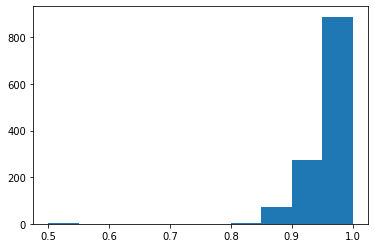

In [ ]:
plt.hist([x for x in dist_to_target[convert_theme] if x != 1])
plt.show()

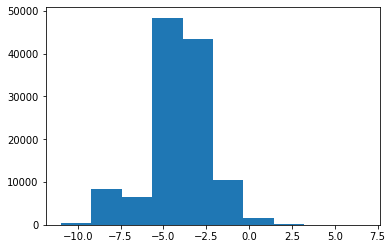

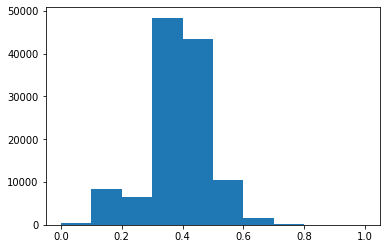

In [ ]:
y = outputs[0][0][0]
x = np.interp(y, (y.min(), y.max()), (0, 1))
plt.hist(y)
plt.show()
plt.hist(x)
plt.show()

### Fine tune Bert for masking

In [ ]:
!pip install simpletransformers

In [ ]:
from simpletransformers.language_modeling import LanguageModelingModel

In [ ]:
model = LanguageModelingModel("bert", "bert-base-multilingual-cased", use_cuda=True)

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def make_good(text):
    text = text.replace('\n', '').replace('\t','')
    ind = 0
    while ind < len(text) and not (text[ind] > 'А' and text[ind] < 'Я'):
        ind += 1
        
    if ind == len(text):
        text = text[text.find(' ') + 1:]
    else:
        text = text[ind:]
    return text

In [ ]:
import pandas as pd
data = pd.read_csv('good_additional_dataset.csv')
data.head()

,Unnamed: 0,texts,prediction,score
0,0,\t1.1. Летом в спортивный лагерь ходили 50 дет...,спорт,0.496684
1,1,\t1.2. На концерте в летнем лагере ребята игра...,музыка,0.621388
2,3,\t1.4. Во время летних соревнований по плавани...,спорт,0.646785
3,4,\t1.5. В спортивную школу во время летних кани...,спорт,0.640304
4,6,\t1.7. Самые крупные животные на нашей планете...,животные,0.407655


In [ ]:
theme = 'животные'
for_train = data[data['prediction'] == theme]['texts'].values
for_train = [make_good(el) + '\n' for el in for_train]

In [ ]:
with open(f'{theme}.txt', 'w') as f:
    f.writelines(for_train)

In [ ]:
train_args = {'learning_rate' : 2e-6,
              'max_seq_length' : 256,
              'num_train_epochs' : 3,
              #'do_lower_case' : True,
              'use_multiprocessing' : True,
              'train_batch_size' : 4,
              #'save_steps' : 50000,
              'overwrite_output_dir': True,
              'load_best_model_at_end' : True,
              'metric_for_best_model' : 'matthews_correlation',
              }
model.train_model(train_file = theme + '.txt', output_dir='outputs', args = train_args)

  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/language_modeling/language_modeling_model.py:842: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  model.parameters(), args.max_grad_norm
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", User

Running Epoch 1 of 3:   0%|          | 0/30 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/30 [00:00<?, ?it/s]

(90, 1.724665410651101)

In [ ]:
mask = "[MASK]"
masked_sentence = f'Во время летних {mask} {mask} {mask} ребята посетили бассейн. Длина плавательной дорожки в бассейне 25 м. После того как первый участник {mask} проплыл часть дорожки, ему осталось проплыть 10 м. Сколько метров уже проплыл участник соревнований?'
masked_sentence = f'У Миши было 3 три {mask}. Два из них он отдал Даше. Сколько {mask} осталось у Миши?'

In [ ]:
model.eval_model(theme+'.txt')

  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/30 [00:00<?, ?it/s]

{'eval_loss': 1.387173241376877, 'perplexity': tensor(4.0035)}

In [ ]:
model.predict(masked_sentence)

AttributeError: ignored